In [3]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

In [4]:
import torch
import torch.utils.data as torch_data

from fastmri.subsample import RandomMaskFunc

from fastmri.utils import *

## Load data

In [5]:
PATH_TO_SOURCE = 'data/ax_t2_single_source/'

PATH_TO_SOURCE_TRAIN = 'data/ax_t2_single_source_train'
PATH_TO_SOURCE_VAL = 'data/ax_t2_single_source_val'
PATH_TO_SOURCE_TEST = 'data/ax_t2_single_source_test'

os.makedirs(PATH_TO_SOURCE_TRAIN, exist_ok=True)
os.makedirs(PATH_TO_SOURCE_VAL, exist_ok=True)
os.makedirs(PATH_TO_SOURCE_TEST, exist_ok=True)

RANDOM_STATE = 42

## Data Loaders

In [7]:
class MRIDataSampler(torch_data.Dataset):
    def __init__(self, path_to_data, center_fractions, accelerations, 
                       shape=(1, 320, 320), seed=None, threshold=1e-7):
        super().__init__()
        self.images = [os.path.join(path_to_data, file) for file in os.listdir(path_to_data) 
                       if file.endswith('npy')]
        self.images = sorted(self.images)

        self._mask_function = RandomMaskFunc(center_fractions=[center_fractions], 
                                             accelerations=[accelerations],
                                             seed=seed
                                            )
        self.mask = self._mask_function(shape, seed=seed).flatten().astype(bool)
        self.threshold = threshold

    def __len__(self):
        return len(self.images)

    def sample_slice(self, slice):
        slice_fft = np.fft.fft2(slice)
        slice_kspace = np.fft.fftshift(slice_fft)

        slice_kspace[:, :, ~self.mask] = 0

        slice_fft = np.fft.ifftshift(slice_kspace)
        sampled_image = np.fft.ifft2(slice_fft)

        sampled_image_abs = np.abs(sampled_image)
        sampled_image_abs -= sampled_image_abs.min()
        sampled_image_abs /= sampled_image_abs.max()

        sampled_image_abs[np.where(sampled_image_abs < self.threshold)] = 0

        return sampled_image_abs.astype(np.float32)

    def __getitem__(self, idx):

        slice = npy_load(self.images[idx])
        slice_sampled = self.sample_slice(slice)

        return self.images[idx], slice, slice_sampled

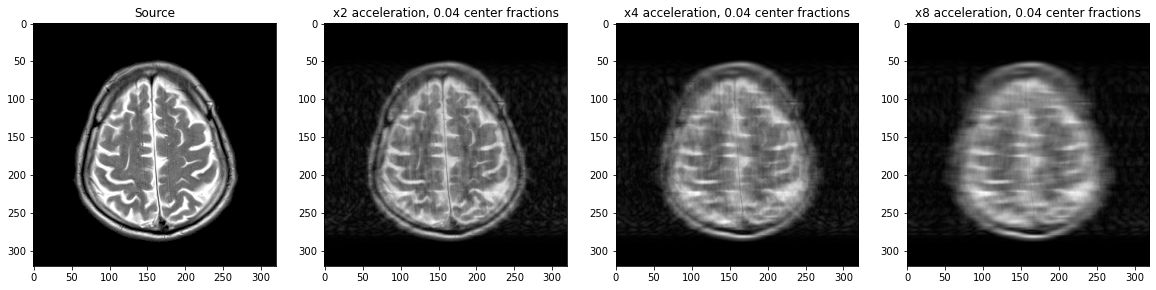

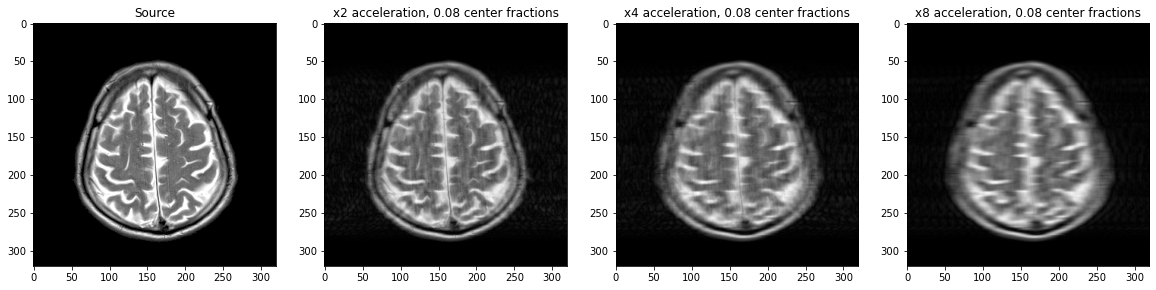

In [8]:
accelerations = [2, 4, 8]
center_fractions = [0.04, 0.08]

i = np.random.randint(0, len(os.listdir(PATH_TO_SOURCE_TRAIN)))

sampled_slices = []

for center_frac in center_fractions:
    fig, axis = plt.subplots(1, len(accelerations)+1, figsize=(20, 9))

    for j, acceleration in enumerate(accelerations, 1):
        train_loader = MRIDataSampler(PATH_TO_SOURCE_TRAIN, center_frac, acceleration, 
                                     seed=RANDOM_STATE, threshold=1e-5)

        name, slice, slice_sampled = train_loader.__getitem__(i)
        sampled_slices.append(slice_sampled)

        axis[j].imshow(slice_sampled[0], cmap='gray', vmin=0, vmax=1)
        axis[j].set_title(f'x{acceleration} acceleration, {center_frac} center fractions', fontsize=12)

    axis[0].imshow(slice[0], cmap='gray', vmin=0, vmax=1)
    axis[0].set_title('Source', fontsize=12)

    plt.show()

In [9]:
for a, sampled_slice in zip(accelerations, sampled_slices):
    print(f'X{a} acceleration:')
    compare_imgs(slice, sampled_slice)

    print()

X2 acceleration:
	MAE	PSNR	SSIM
score	0.053	21.784	0.627

X4 acceleration:
	MAE	PSNR	SSIM
score	0.063	19.811	0.559

X8 acceleration:
	MAE	PSNR	SSIM
score	0.066	19.155	0.532



## Train test split

In [7]:
samples = [s for s in os.listdir(PATH_TO_SOURCE) if s.endswith('npy')]

train_val_samples, test_samples = train_test_split(samples, test_size=0.2, random_state=RANDOM_STATE)
train_samples, val_samples = train_test_split(train_val_samples, test_size=0.2, random_state=RANDOM_STATE)

print(len(train_samples), len(val_samples), len(test_samples))

47024 11756 14696


In [8]:
for sample in tqdm(train_samples):
    pass
    #shutil.copy(os.path.join(PATH_TO_SOURCE, sample), os.path.join(PATH_TO_SOURCE_TRAIN, sample))

for sample in tqdm(val_samples):
    pass
    #shutil.copy(os.path.join(PATH_TO_SOURCE, sample), os.path.join(PATH_TO_SOURCE_VAL, sample))
    
for samples in tqdm(test_samples):
    pass
    #shutil.copy(os.path.join(PATH_TO_SOURCE, sample), os.path.join(PATH_TO_SOURCE_TEST, sample))

## Data sampling

In [8]:
acceleration = 8
center_fraction = 0.08
parts = ['train', 'val', 'test']

for part in parts:

    if part == 'train':
        path_to_sources = PATH_TO_SOURCE_TRAIN
    elif part == 'val':
        path_to_sources = PATH_TO_SOURCE_VAL
    elif part == 'test':
        path_to_sources = PATH_TO_SOURCE_TEST
    else:
        raise ValueError()

    path_to_save = f'data/ax_t2_single_sampled_x{acceleration}_{part}/'
    print(path_to_sources, path_to_save, sep=' -> ')
    os.makedirs(path_to_save, exist_ok=True)

    for path, _, slice_sampled in tqdm(MRIDataSampler(path_to_sources, center_fraction, 
                                                      acceleration, seed=RANDOM_STATE, threshold=1e-5)):
        name = os.path.split(path)[1]

        with open(os.path.join(path_to_save, name), 'wb') as f:
            np.save(f, slice_sampled)

data/ax_t2_single_source_train -> data/ax_t2_single_sampled_x8_train/



data/ax_t2_single_source_val -> data/ax_t2_single_sampled_x8_val/



data/ax_t2_single_source_test -> data/ax_t2_single_sampled_x8_test/
